In [1]:
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from utils import load_all_images_3channel, get_class_name

PIXELS = 200

In [2]:
# settings
plt.style.use('seaborn')
plt.show()
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (8, 5)

In [3]:
x, y = load_all_images_3channel(
    classes=["sunny", "cloudy", "foggy", "rainy", "snowy"], pixels=PIXELS
)

 has processed 18039

In [4]:
# make them as numpy array
x = np.array(x)
y = np.array(y)

x.shape, y.shape

((18039, 200, 200, 3), (18039,))

In [5]:
# shuffle and split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, train_size=0.7, shuffle=True, random_state=777
)

y_train_labels = y_train.copy()
y_test_labels = y_test.copy()

# convert class vector into binary matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train.shape, y_train.shape

((12627, 200, 200, 3), (12627, 5))

# Feature extraction
## CNN with 3-Color Channels

In [ ]:
model = Sequential([
    # feature detector portion of model
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(PIXELS, PIXELS, 3)),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(pool_size=(2, 2)),

    # classifier portion of model
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=5, activation='sigmoid'),
])

model.summary()

In [ ]:
# set optimizer and metrics
model.compile(
    optimizer=RMSprop(learning_rate=0.001, momentum=0.3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# train model
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=20,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(patience=3, min_delta=0.0001, restore_best_weights=True),
        ReduceLROnPlateau(patience=1, factor=0.1),
    ],
)


170/170 [==============================] - 2s 11ms/step - loss: 0.2327 - accuracy: 0.7380


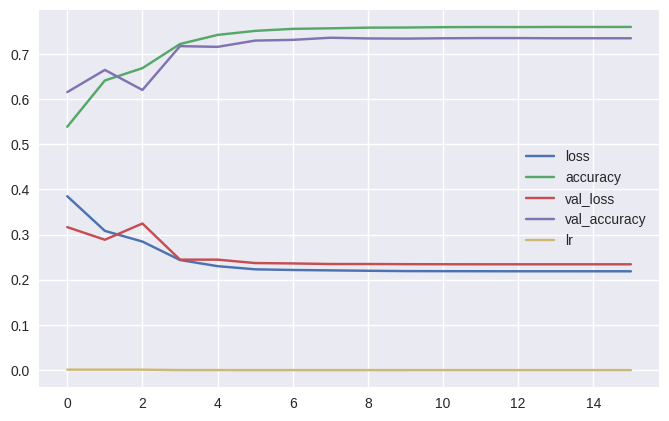

In [8]:
model.evaluate(x_test, y_test)
pd.DataFrame(history.history).plot()
plt.show()

170/170 [==============================] - 2s 9ms/step


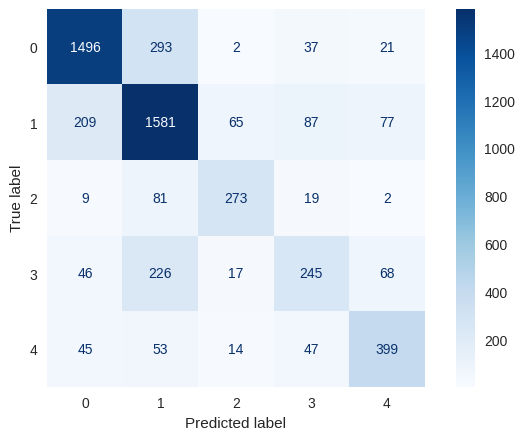

In [9]:
predictions = model.predict(x_test)
pred_values = np.argmax(predictions, axis=1)

cm = confusion_matrix(y_test_labels, pred_values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

### Sample of missed images

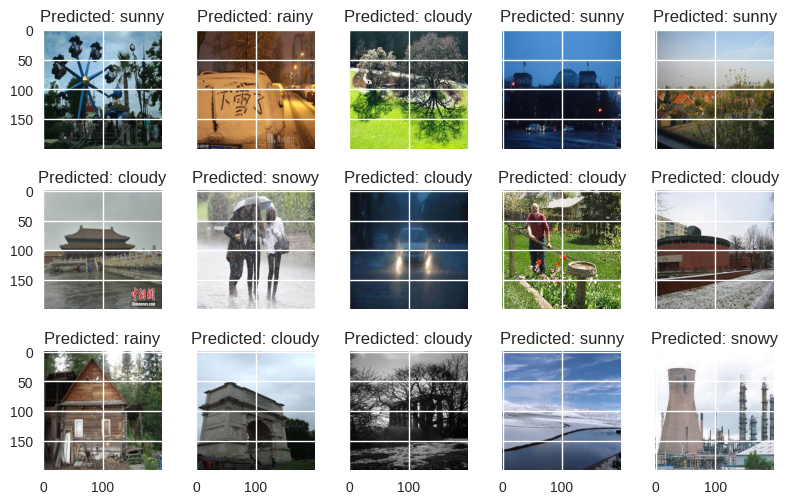

<Figure size 400x700 with 0 Axes>

In [10]:
missed_features = x_test[pred_values != y_test_labels]
missed_labels = pred_values[pred_values != y_test_labels]

# first 10 missed predictions
fig, axs = plt.subplots(3, 5, sharex=True, sharey=True)
fig.tight_layout(h_pad=2)
plt.figure(figsize=(4, 7), dpi=100)

for i, ax in enumerate(axs.flatten()):
    ax.imshow(missed_features[i])
    ax.set_title(f'Predicted: {get_class_name(missed_labels[i])}')

plt.show()

In [11]:
model.save('CNN.tf')

INFO:tensorflow:Assets written to: CNN.tf/assets


INFO:tensorflow:Assets written to: CNN.tf/assets
